In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.vaep.formula as vaepformula

In [2]:
## Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [3]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
    actiontypes = spadlstore["actiontypes"]
    bodyparts = spadlstore["bodyparts"]
    results = spadlstore["results"]
print("nb of games:", len(games))

nb of games: 64


In [4]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        actions
        .merge(actiontypes, how="left")
        .merge(bodyparts, how="left")
        .merge(players, how="left")
        .merge(teams, how="left")
        .merge(results, how="left")
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds,values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 64/64 [00:06<00:00,  9.74it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds',
       'timestamp', 'team_id', 'player_id', 'start_x', 'start_y', 'end_x',
       'end_y', 'type_id', 'result_id', 'bodypart_id', 'action_id',
       'type_name', 'bodypart_name', 'player_name', 'nickname', 'team_name',
       'result_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

### Most valuable players

In [5]:
A["count"] = 1

# These are useless events that don't measure player skill
       
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
50,3308,Kieran Trippier,3.828762,4.290228,-0.461465,690
6,3009,Kylian Mbappé,3.495352,3.563664,-0.068312,495
17,3089,Kevin De Bruyne,3.219511,3.414068,-0.194557,716
92,3621,Eden Hazard,3.117713,3.337505,-0.219793,691
122,4320,Neymar,3.045940,3.353854,-0.307914,749
36,3244,John Stones,3.004977,2.437726,0.567251,937
599,20004,Paul Pogba,2.939419,2.857957,0.081462,676
352,5574,Toni Kroos,2.872660,3.054151,-0.181491,646
152,5186,Denis Cheryshev,2.781063,3.787928,-1.006865,214
71,3501,Philippe Coutinho,2.670792,2.572344,0.098448,703


In [6]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
352,5574,Toni Kroos,2.872660,3.054151,-0.181491,646,289,0.894600,0.951120
152,5186,Denis Cheryshev,2.781063,3.787928,-1.006865,214,312,0.802230,1.092672
451,5674,Moussa Wagué,1.726478,1.701880,0.024598,168,208,0.747034,0.736390
34,3237,Sergio Agüero,1.559966,1.518070,0.041895,137,193,0.727445,0.707908
525,6196,Yerry Mina,2.456153,2.292256,0.163897,325,315,0.701758,0.654930
251,5473,Ahmed Musa,1.705044,1.749072,-0.044028,162,220,0.697518,0.715529
121,4319,Edinson Cavani,2.646485,2.688047,-0.041562,226,355,0.670940,0.681477
122,4320,Neymar,3.045940,3.353854,-0.307914,749,478,0.573503,0.631479
50,3308,Kieran Trippier,3.828762,4.290228,-0.461465,690,602,0.572406,0.641396
6,3009,Kylian Mbappé,3.495352,3.563664,-0.068312,495,550,0.571967,0.583145


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-28 20:00:00 England 0-1 Belgium 9' dribble Michy Batshuayi Tunga


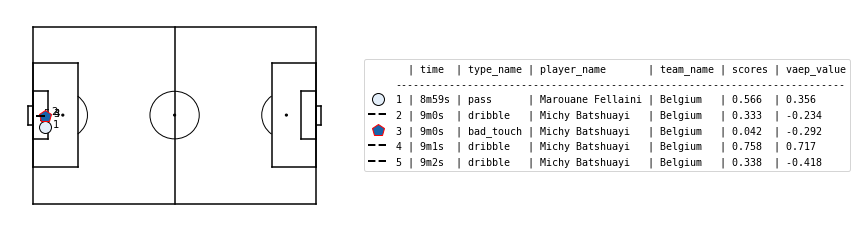

2018-07-02 20:00:00 Belgium 3-2 Japan 24' cross Dries Mertens


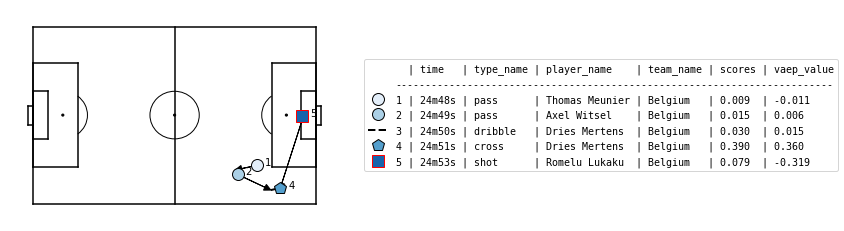

2018-06-28 20:00:00 England 0-1 Belgium 8' pass Marouane Fellaini-Bakkioui


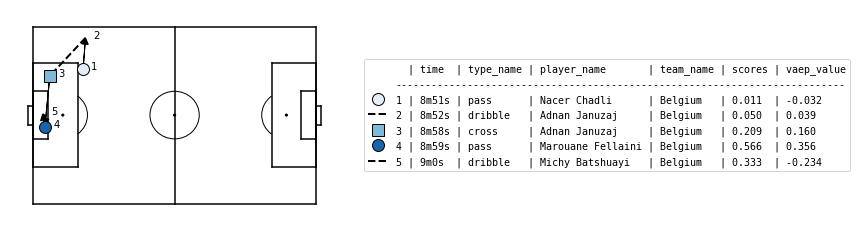

2018-07-02 20:00:00 Belgium 3-2 Japan 77' cross Nacer Chadli


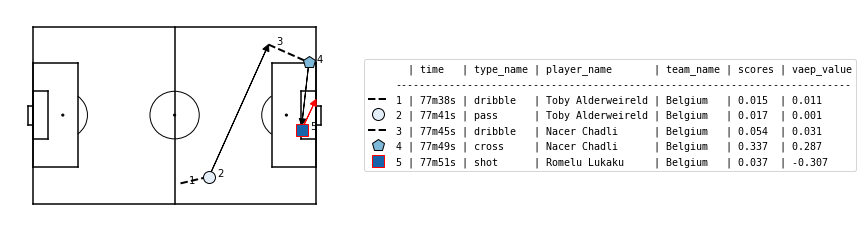

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' take_on Michy Batshuayi Tunga


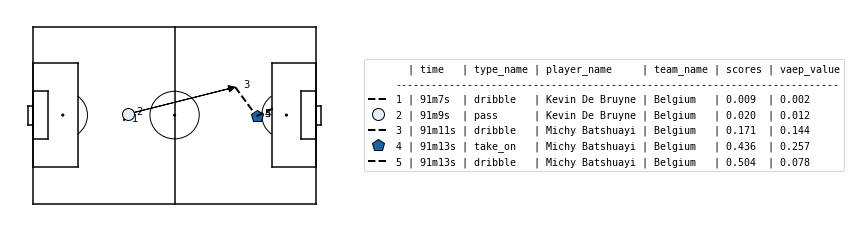

2018-07-02 20:00:00 Belgium 3-2 Japan 73' cross Eden Hazard


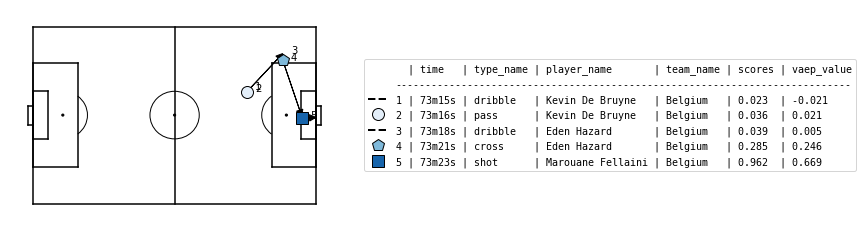

2018-07-10 20:00:00 France 1-0 Belgium 46' pass Axel Witsel


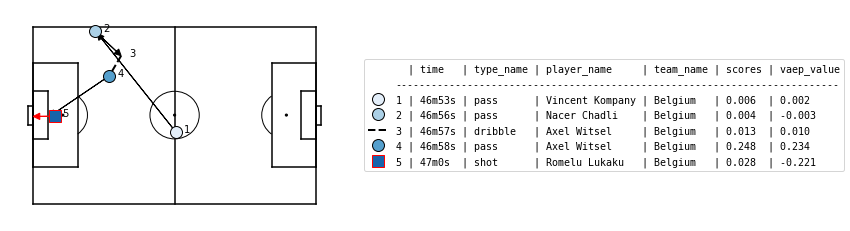

2018-06-18 17:00:00 Belgium 3-0 Panama 68' pass Kevin De Bruyne


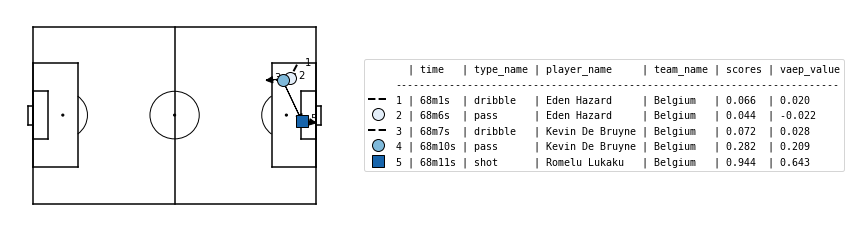

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' cross Youri Tielemans


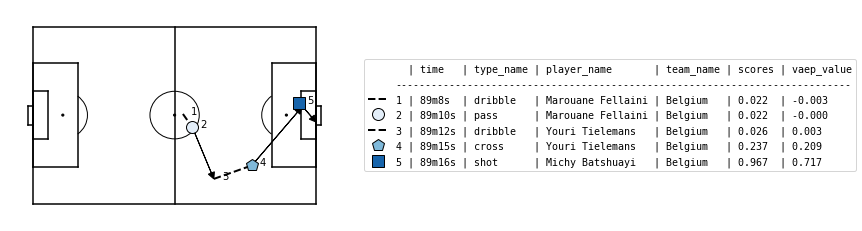

2018-07-10 20:00:00 France 1-0 Belgium 21' corner_crossed Nacer Chadli


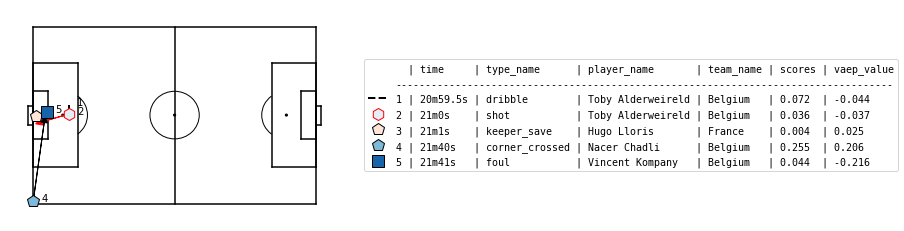

2018-07-02 20:00:00 Belgium 3-2 Japan 93' pass Thomas Meunier


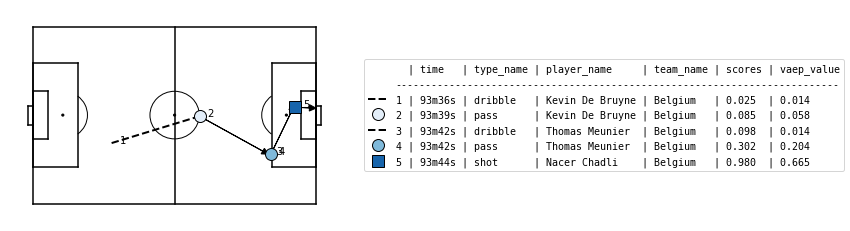

2018-06-23 14:00:00 Belgium 5-2 Tunisia 47' pass Thomas Meunier


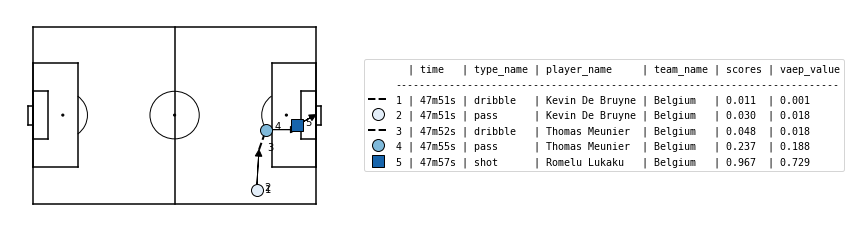

2018-07-02 20:00:00 Belgium 3-2 Japan 87' dribble Romelu Lukaku Menama


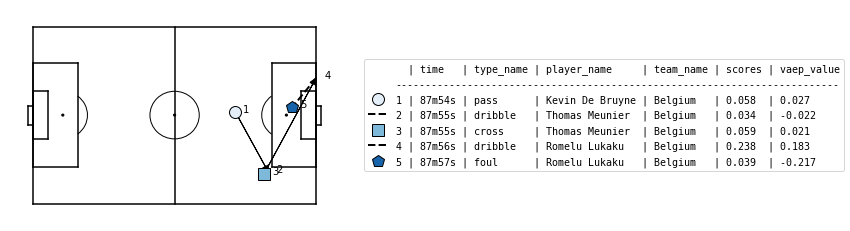

2018-06-18 17:00:00 Belgium 3-0 Panama 35' cross Thomas Meunier


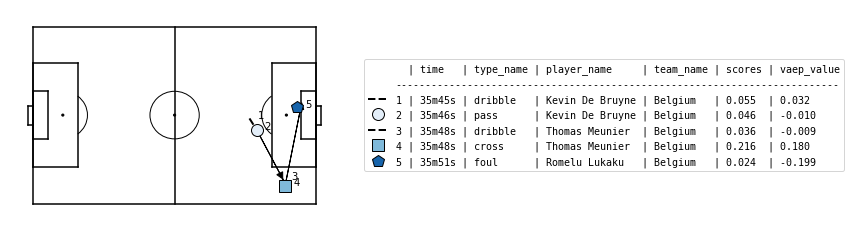

2018-06-23 14:00:00 Belgium 5-2 Tunisia 80' cross Kevin De Bruyne


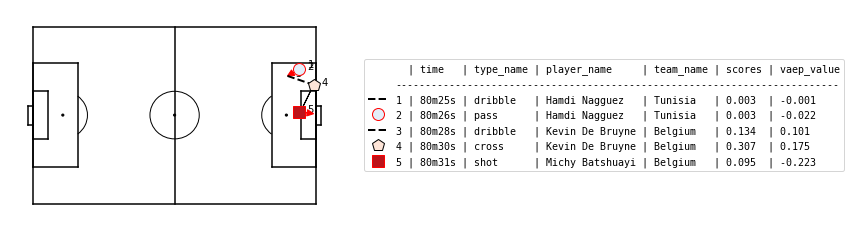

2018-07-02 20:00:00 Belgium 3-2 Japan 85' cross Thomas Meunier


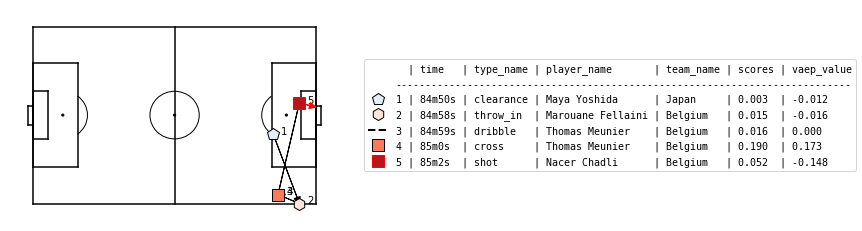

2018-07-06 21:00:00 Brazil 1-2 Belgium 61' dribble Vincent Kompany


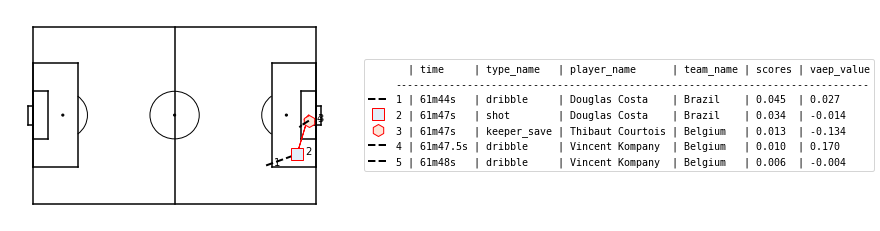

2018-07-14 16:00:00 Belgium 2-0 England 3' cross Nacer Chadli


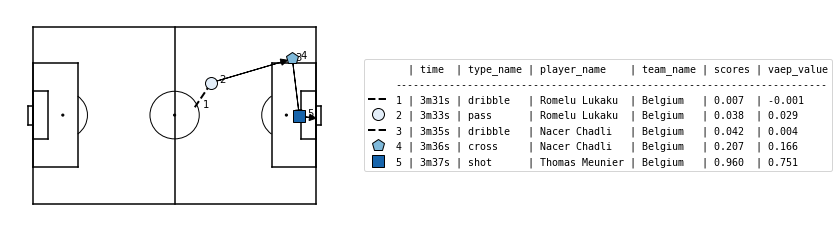

2018-07-02 20:00:00 Belgium 3-2 Japan 79' dribble Vincent Kompany


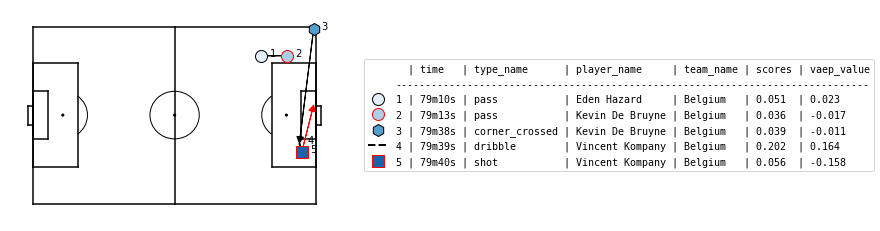

2018-06-28 20:00:00 England 0-1 Belgium 8' cross Adnan Januzaj


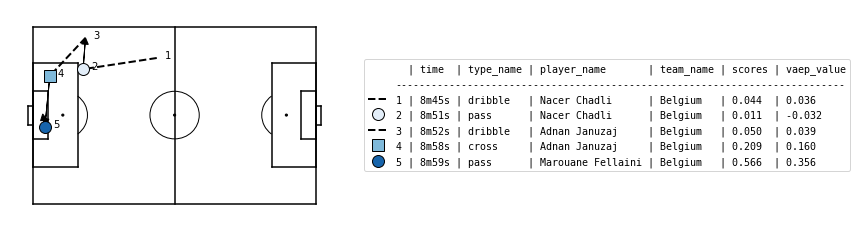

2018-07-10 20:00:00 France 1-0 Belgium 60' dribble Kevin De Bruyne


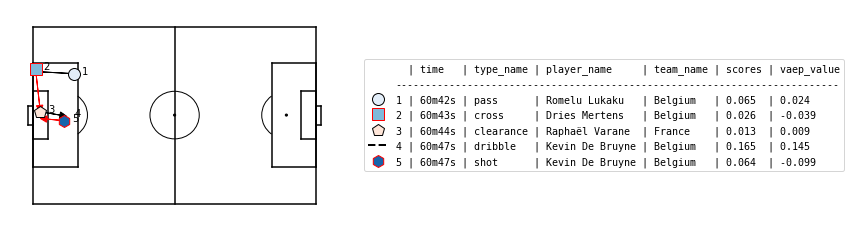

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' dribble Michy Batshuayi Tunga


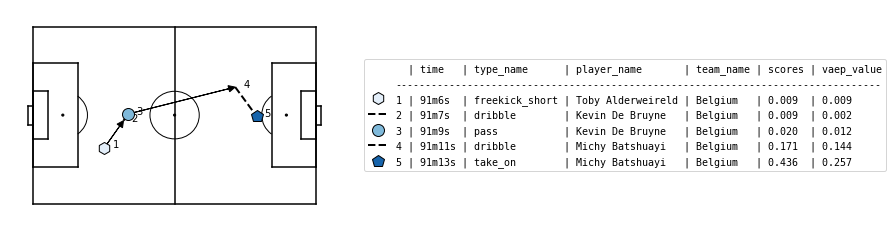

2018-07-02 20:00:00 Belgium 3-2 Japan 48' dribble Eden Hazard


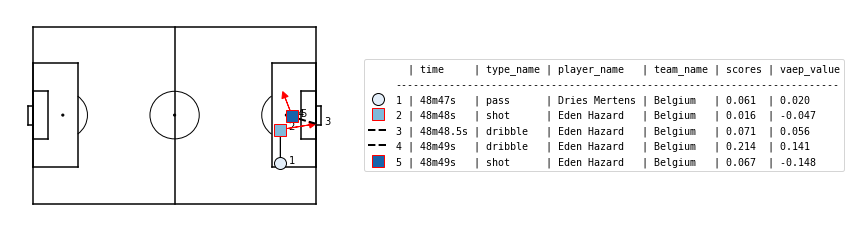

2018-06-23 14:00:00 Belgium 5-2 Tunisia 46' cross Kevin De Bruyne


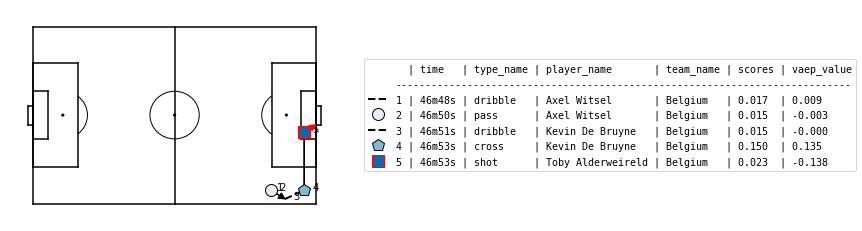

2018-07-14 16:00:00 Belgium 2-0 England 81' dribble Eden Hazard


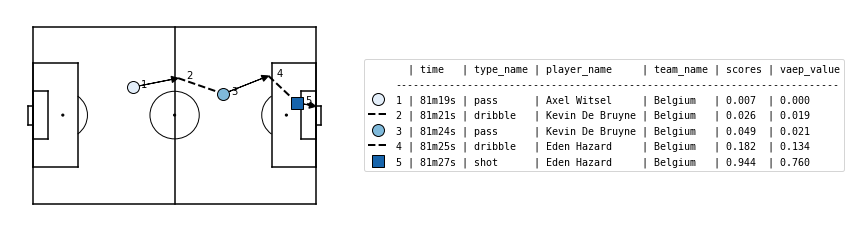

2018-07-06 21:00:00 Brazil 1-2 Belgium 14' pass Nacer Chadli


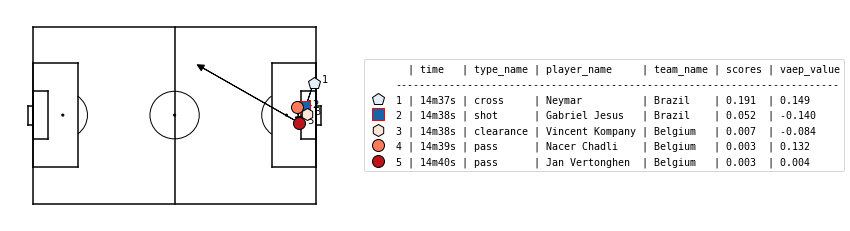

2018-06-23 14:00:00 Belgium 5-2 Tunisia 80' dribble Michy Batshuayi Tunga


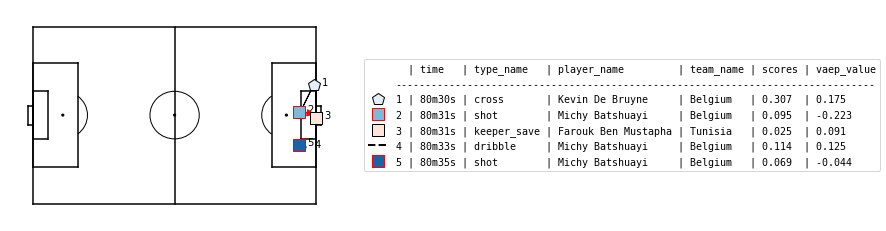

2018-07-02 20:00:00 Belgium 3-2 Japan 88' dribble Nacer Chadli


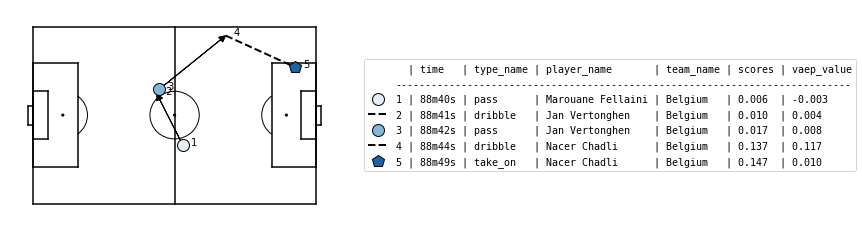

2018-07-02 20:00:00 Belgium 3-2 Japan 27' cross Kevin De Bruyne


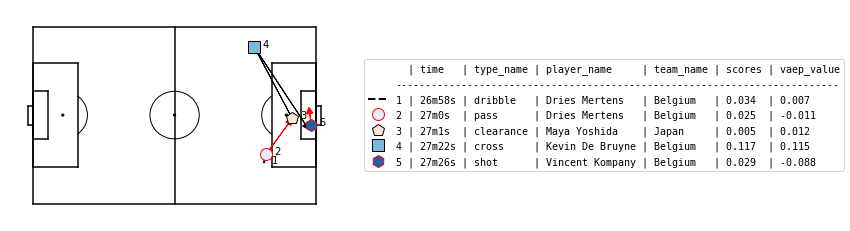

2018-06-23 14:00:00 Belgium 5-2 Tunisia 79' dribble Michy Batshuayi Tunga


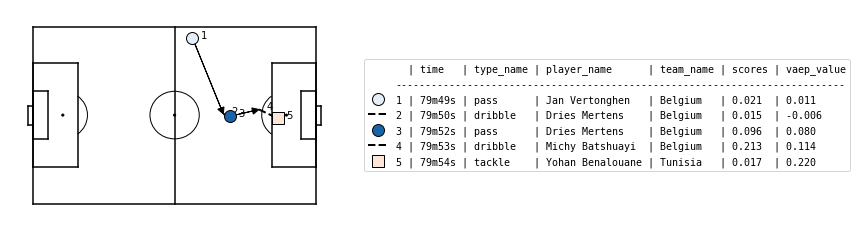

2018-06-23 14:00:00 Belgium 5-2 Tunisia 50' take_on Eden Hazard


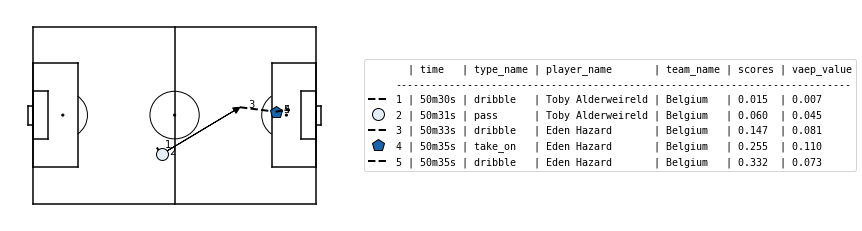

2018-07-10 20:00:00 France 1-0 Belgium 64' cross Dries Mertens


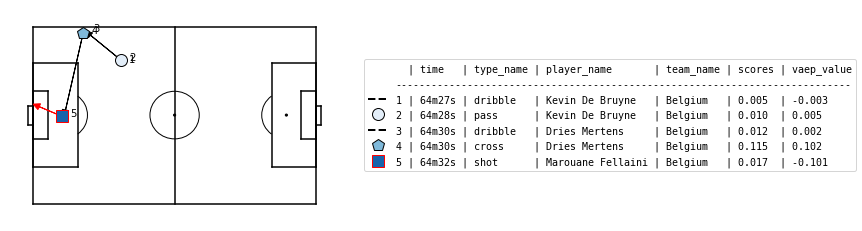

2018-06-23 14:00:00 Belgium 5-2 Tunisia 80' dribble Kevin De Bruyne


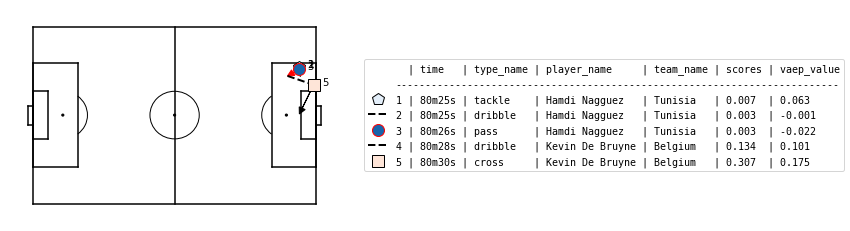

2018-07-02 20:00:00 Belgium 3-2 Japan 61' cross Thomas Meunier


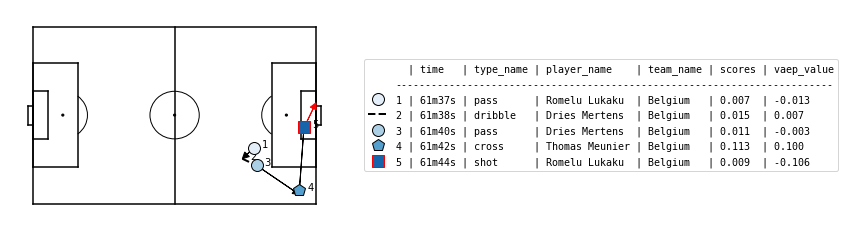

2018-07-14 16:00:00 Belgium 2-0 England 11' dribble Kevin De Bruyne


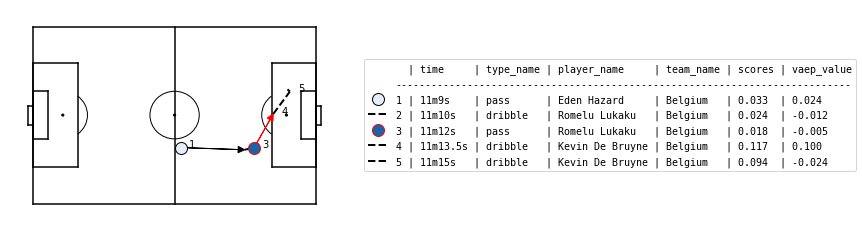

2018-06-18 17:00:00 Belgium 3-0 Panama 0' cross Yannick Ferreira Carrasco


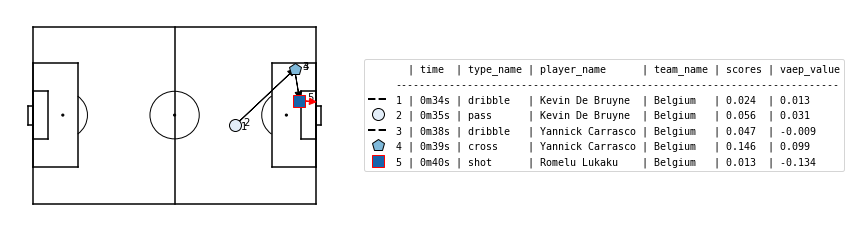

2018-06-28 20:00:00 England 0-1 Belgium 35' corner_crossed Thorgan Hazard


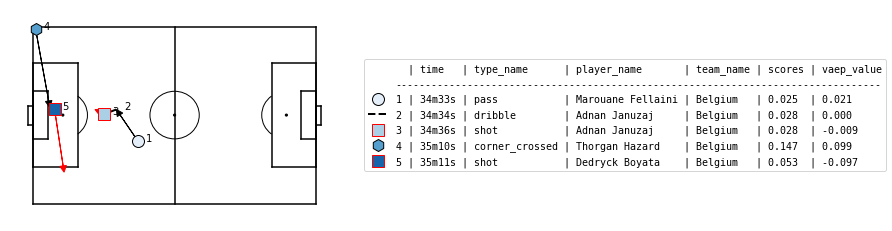

2018-06-18 17:00:00 Belgium 3-0 Panama 91' pass Moussa Sidi Yaya Dembélé


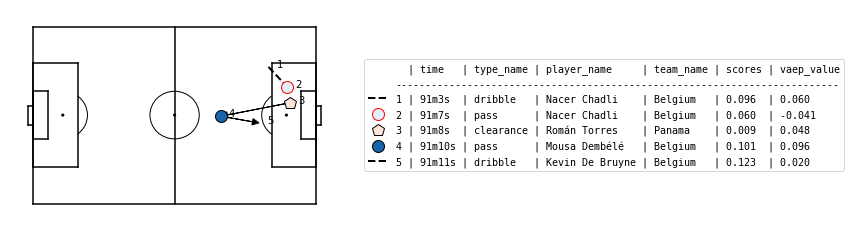

2018-06-23 14:00:00 Belgium 5-2 Tunisia 12' cross Romelu Lukaku Menama


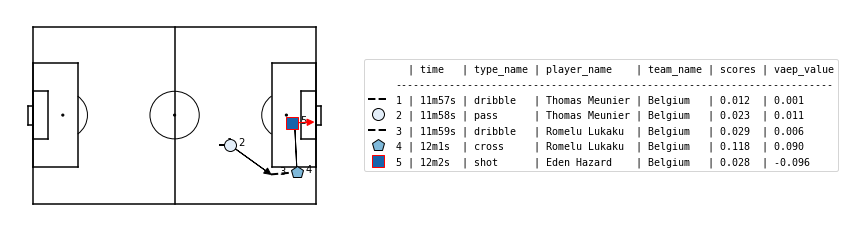

2018-07-14 16:00:00 Belgium 2-0 England 17' tackle Vincent Kompany


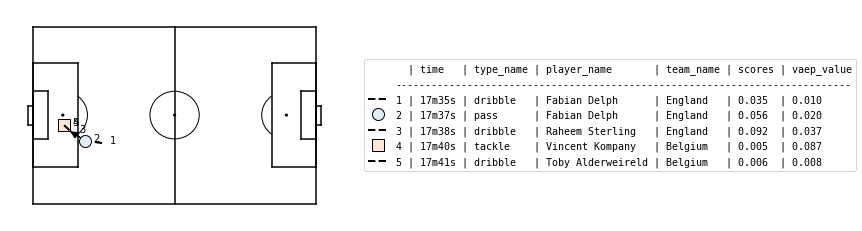

2018-06-23 14:00:00 Belgium 5-2 Tunisia 75' pass Dries Mertens


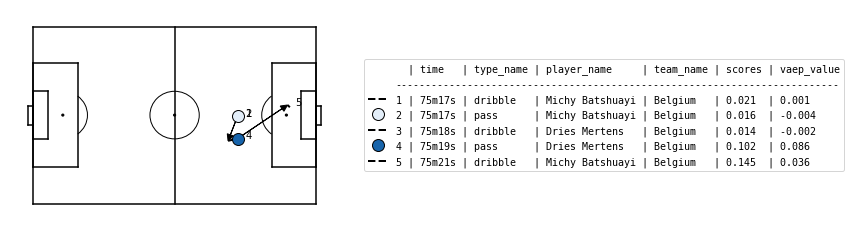

2018-07-06 21:00:00 Brazil 1-2 Belgium 7' dribble Kevin De Bruyne


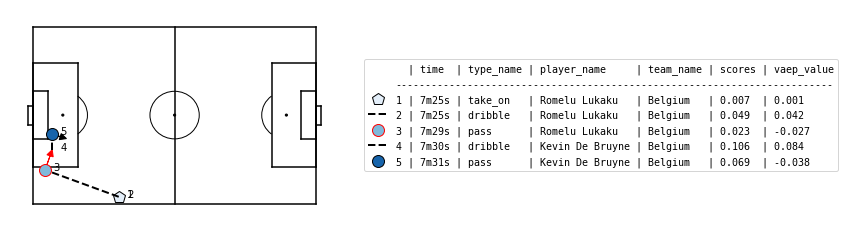

2018-07-02 20:00:00 Belgium 3-2 Japan 8' pass Dries Mertens


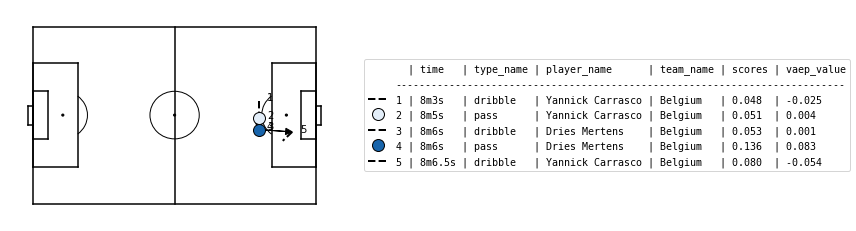

2018-06-23 14:00:00 Belgium 5-2 Tunisia 60' pass Eden Hazard


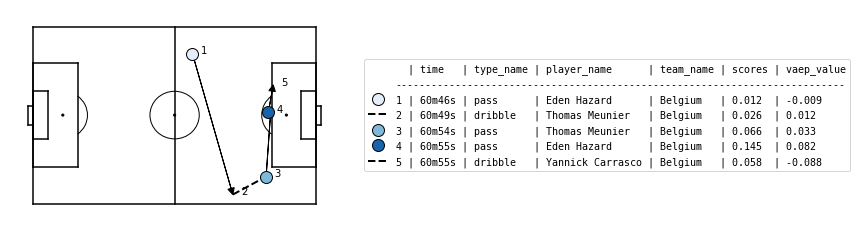

2018-07-02 20:00:00 Belgium 3-2 Japan 67' cross Thomas Meunier


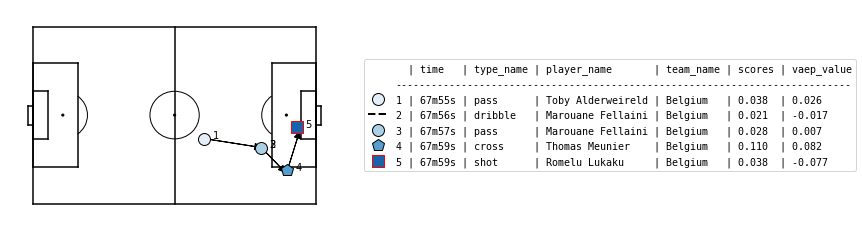

2018-06-28 20:00:00 England 0-1 Belgium 90' cross Michy Batshuayi Tunga


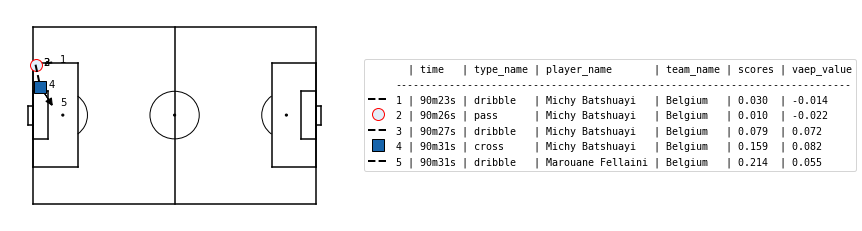

2018-07-06 21:00:00 Brazil 1-2 Belgium 64' dribble Eden Hazard


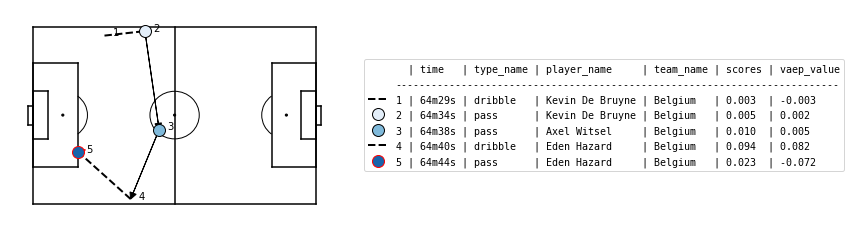

2018-07-02 20:00:00 Belgium 3-2 Japan 85' pass Nacer Chadli


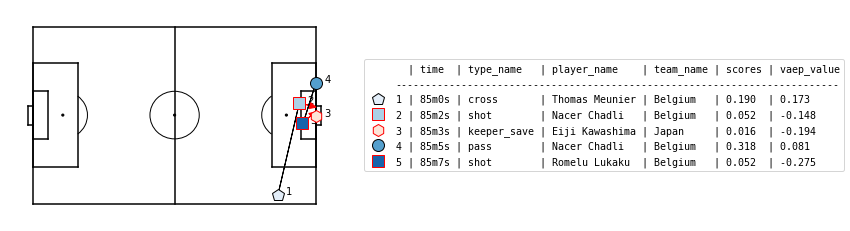

2018-06-23 14:00:00 Belgium 5-2 Tunisia 50' dribble Eden Hazard


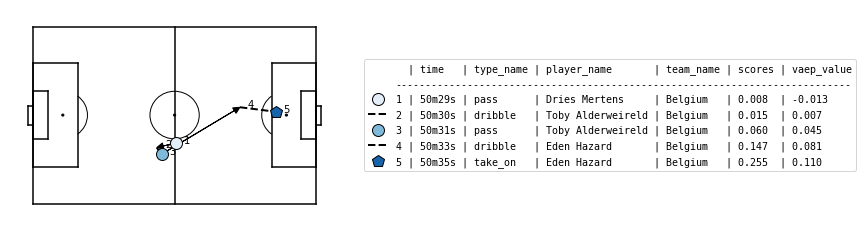

2018-07-02 20:00:00 Belgium 3-2 Japan 93' dribble Thibaut Courtois


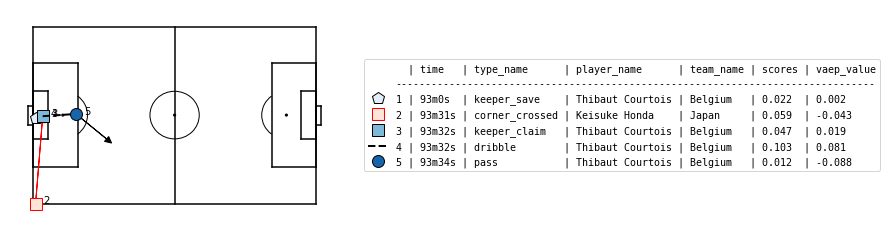

In [7]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,50):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)